## STAT 5540 Project
### Forecasting of power demand in Colorado on Sunday May 1st from 5-6 PM

## Introduction

Forecasting of power demand plays an essential role in the electric industry, as it provides the basis for making decisions in power system planning and operation. Accurate forecasts of electricity demandinform investment decisions about power generation and supporting network infrastructure. Of major interest to energy policymakers, power utilities, and private investors alike, forecasts are also essential for development professionals. Inaccurate forecasts, whether they over- or under predict demand, can have dire social and economic consequences. Underestimating demand results in supply shortages and forced power outages, with serious consequences for productivity and economic growth. Overestimating demand can lead to overinvestment in generation capacity, possible financial distress, and, ultimately, higher electricity prices. In line with this importance of forecasting of power demand, this project aims to understand the overall electricity demand data and find the best model to predict the future data, specifically electric energy demand in Colorado on Sunday May 1st from 5-6 PM.

## Dataset

In mid-2015, the EIA began collecting hourly energy demand data across the contiguous United States. The Energy demand data are freely available and constantly updated by the government EIA website. The data for this project are imported from the EIA website using the EIA R package. It provides utilities to convert dates and provides tools to update a dataset whenever new data is available. Once the data are imported, I go over the dataset for data preprocessing. I use IQR (Interquartile Range) rule to find outliers. I multiply the interquartile range (IQR) by 1.5 and add it to the third quartile. Any number greater than this is a suspected outlier. Likewise, subtract 1.5 x IQR value from the first quartile, and any number smaller than this is a suspected outlier as well. After the outliers are identified, I replace them with the mean of the previous and the next value.

In [1]:
#install.packages('eia')
library(eia)
library(ggplot2)
library(astsa)
library(itsmr)
library(tseries)
library(forecast)

# API Key
eia_set_key("BhhTazUuGEdIaDdGH1ghwxvMJDLCOzG4NyBHjhsd")
eia_get_key()

# Import Data from EIA

eia_cats(3389994)
id = "EBA.PSCO-ALL.D.H"
data =  eia_series(id)

df = data.frame(data$data)

head(df)

# Data pre-processing (Remove NA values)
dim(df)
df = na.omit(df)
dim(df)

# Re-arrange the date and the value in time order
df = data.frame(rev(df$date), rev(df$value))
names(df) = c("date", "value");head(df)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


다음의 패키지를 부착합니다: ‘tseries’


The following object is masked from ‘package:itsmr’:

    arma



다음의 패키지를 부착합니다: ‘forecast’


The following object is masked from ‘package:itsmr’:

    forecast


The following object is masked from ‘package:astsa’:

    gas


Key stored successfully in package environment.



[1] "BhhTazUuGEdIaDdGH1ghwxvMJDLCOzG4NyBHjhsd"

$category
# A tibble: 1 × 4
  category_id parent_category_id name                                      notes
  <chr>       <chr>              <chr>                                     <chr>
1 3389994     3389934            Public Service Company of Colorado (PSCO) ""   

$childseries
# A tibble: 2 × 5
  series_id         name                             f     units    updated     
  <chr>             <chr>                            <chr> <chr>    <chr>       
1 EBA.PSCO-ALL.D.H  Demand for Public Service Compa… H     megawat… 02-MAY-22 1…
2 EBA.PSCO-ALL.D.HL Demand for Public Service Compa… HL    megawat… 02-MAY-22 1…

,value,date,year,month,week
,<dbl>,<dttm>,<int>,<int>,<int>
1,5688,2022-05-02 16:00:00,2022,5,18
2,5635,2022-05-02 15:00:00,2022,5,18
3,5475,2022-05-02 14:00:00,2022,5,18
4,5128,2022-05-02 13:00:00,2022,5,18
5,4678,2022-05-02 12:00:00,2022,5,18
6,4419,2022-05-02 11:00:00,2022,5,18


[1] 59938     5

[1] 59909     5

,date,value
,<dttm>,<dbl>
1,2015-07-01 07:00:00,4875
2,2015-07-01 08:00:00,4618
3,2015-07-01 09:00:00,4427
4,2015-07-01 10:00:00,4344
5,2015-07-01 11:00:00,4374
6,2015-07-01 12:00:00,4505


[1] 60576

[1] 24

[1] 6057

[1] 7337.5

[1] 2981.5

[1] 5679

[1] 1360  186 1363    0    0  370

[1] 12571 12572 12956 22724 32327 41060

[1] 5719

[1] 5719

[1] 5205

[1] 5012

[1] 4318

[1] 4971

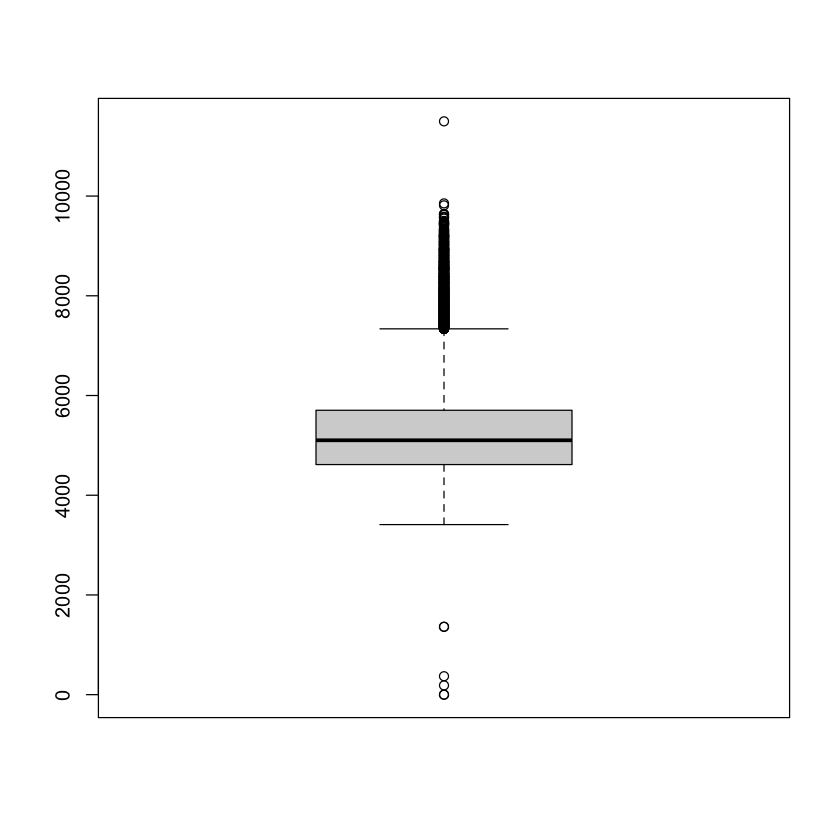

In [4]:
# There is an outlier, so find the value
max(df$value)
which.max(df$value)
df$value[which.max(df$value)] = 6057
df$value[24]

# There are still outliers, so find the values and replace them with the average of adjacent values
boxplot(df$value)
iqr_upper = as.numeric(quantile(df$value, 0.75) + (quantile(df$value, 0.75) - quantile(df$value, 0.25))*1.5);iqr_upper
iqr_lower = as.numeric(quantile(df$value, 0.25) - (quantile(df$value, 0.75) - quantile(df$value, 0.25))*1.5);iqr_lower

#df$value[df$value > iqr_upper] # too many values, and there seems no outlier in the plot. Let's not consider upper outlier
df$value[9727] = mean(df$value[9726], df$value[9728]);df$value[9727]

df$value[df$value < iqr_lower] # 6 values seem outliers and I will replace them with the average value of the very adjacent two values.

which(df$value < iqr_lower)
df$value[12571] = mean(df$value[12570], df$value[12573]);df$value[12571]
df$value[12572] = mean(df$value[12570], df$value[12573]);df$value[12572]
df$value[12956] = mean(df$value[12955], df$value[12957]);df$value[12956]
df$value[22724] = mean(df$value[22723], df$value[22725]);df$value[22724]
df$value[32327] = mean(df$value[32326], df$value[32328]);df$value[32327]
df$value[41060] = mean(df$value[41059], df$value[41061]);df$value[41060]

## Methodology

Once data preprocessing is done, I plot the dataset (x = date, y = demand) as well as ACF (Auto Correlation Function) and PACF (Partial ACF). The plots show strong seasonality, and ACF decays slowly, and this means that the time series is not stationary.

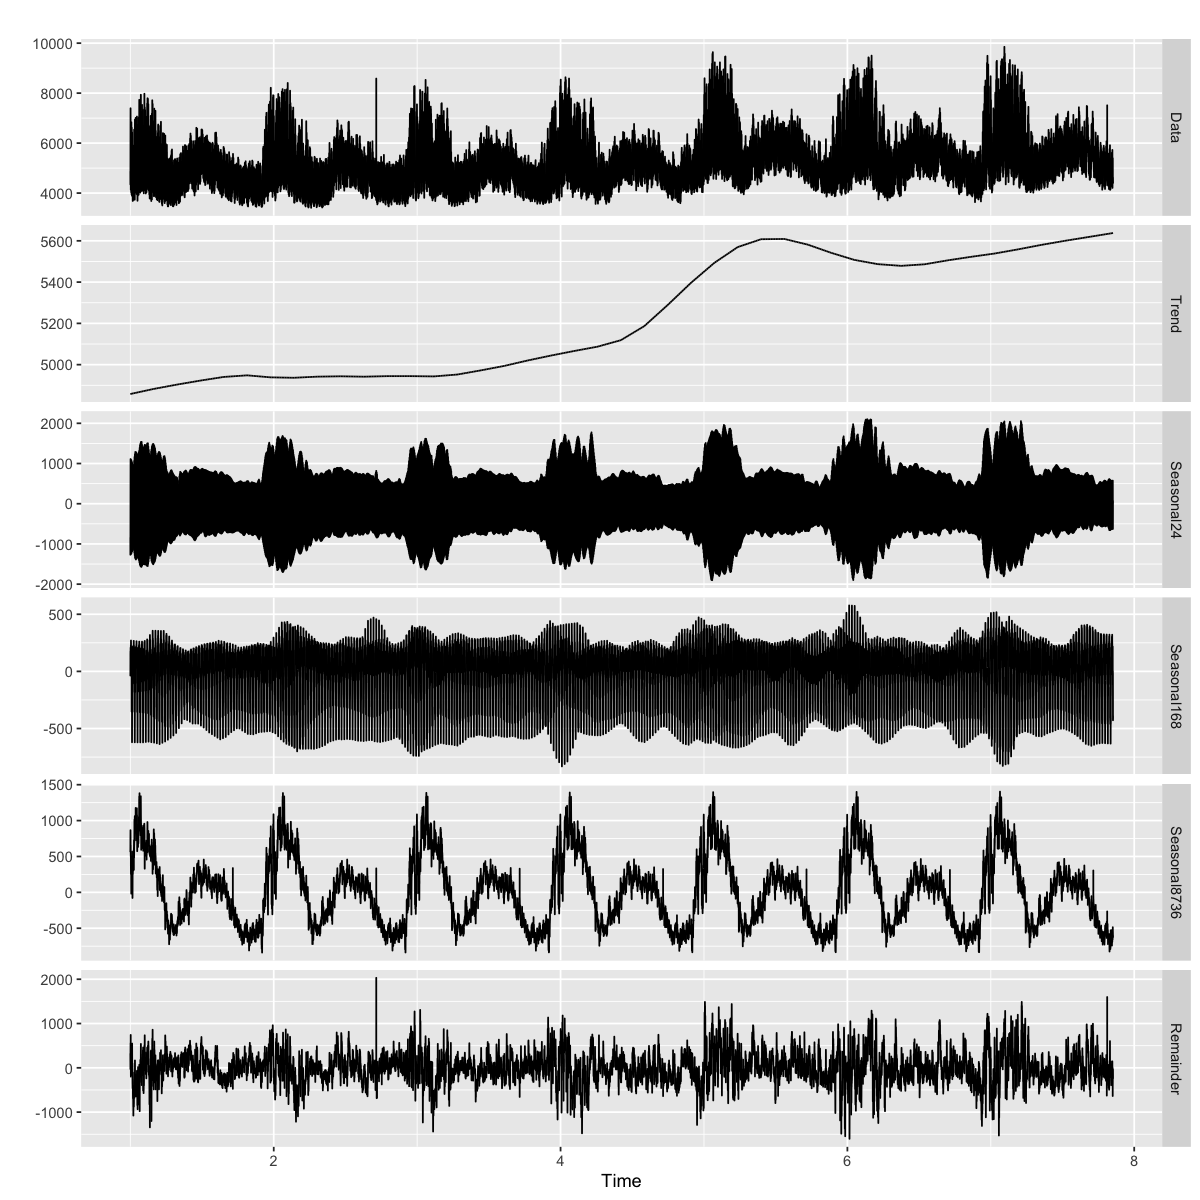

In [7]:
# With Annual Seasonality
options(repr.plot.width = 10, repr.plot.height = 10)
mymsts_annual = msts(df$value, seasonal.periods = c(24, 24*7, 24*7*52))

mymsts_annual  %>% head(length(mymsts_annual)) %>% mstl() %>% autoplot()

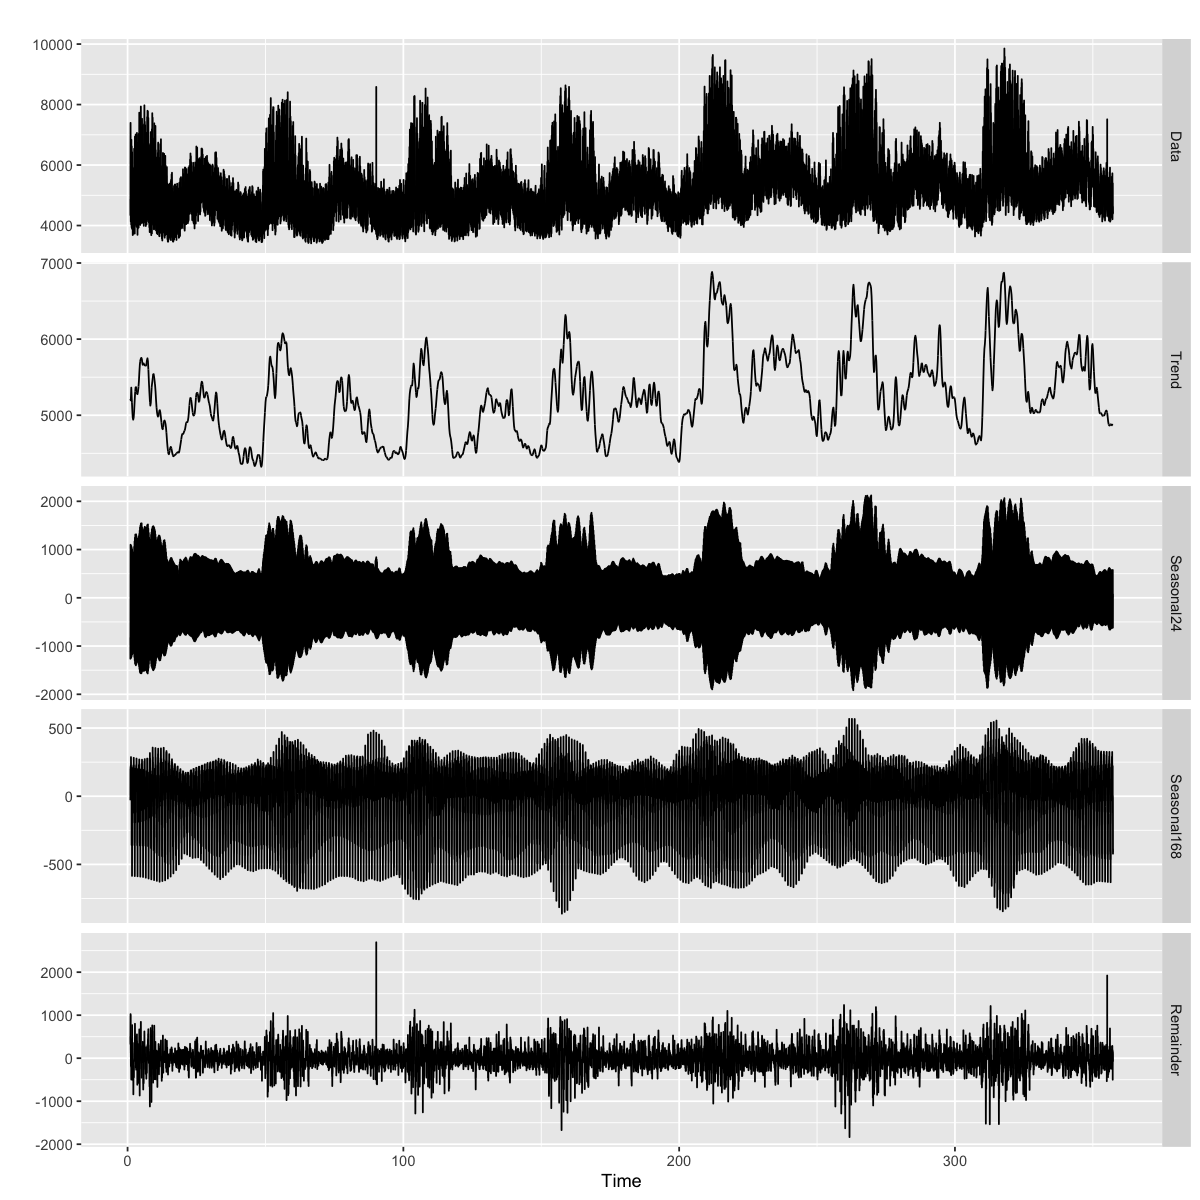

In [8]:
# Without Annual Seasonality
options(repr.plot.width = 10, repr.plot.height = 10)
mymsts = msts(df$value, seasonal.periods = c(24, 24*7))

mymsts  %>% head(length(mymsts)) %>% mstl() %>% autoplot()

The fact that ACF and PACF decay exponentially as lag gets larger suggests that ARMA model to be selected. Since the time series is non-stationary and it has seasonality in it, I decide to use SARIMA model. In addition, the time series has multiple seasonality, daily seasonality, weekly seasonality, and annual seasonality as below. All this seasonality should be considered, when we choose the model, so the msts() function is selected to make the time series with multiple seasonality, daily(24), weekly(24*7), and yearly(24 * 7 * 52), and use auto.arima() function to find the best model.

However, it takes significant amount of time to find the best model using auto.arima() with annual seasonality. So, considering the value we are predicting is only less than 36 lags away from the present and the trend is not very significant in this dataset, I decide not to consider the annual seasonality, but consider only daily and weekly seasonality to predict the electric energy demand in Colorado on Sunday May 1st from 5-6 PM.
I split the data, the first 80% of the dataset as training dataset and the rest and the latest 20% of the dataset as test dataset. First, I use auto.arima() with the training dataset to find the best model, and it returns SARIMA(3,0,0)(0,1,0)[168] model. I test ‘test data’ using this model to find out whether this model fits the dataset. However, since the model doesn’t consider the annual seasonality, it doesn’t fit the model very well. Secondly, I use auto.arima() with the test data just to see the difference, but it returns the exact same SARIMA model. This does not fit either as expected, because it also doesn’t consider the annual seasonality. So, to avoid the impact caused by the annual seasonality, I consider only the 1,000 recent data. I think 1,000 data is big enough to predict the next 36 (29 to be exact) data and it is also small enough to ignore the trend effect as well as the impact due to the annual seasonality. I use auto.arima() and the result is SARIMA(2,1,1)(0,1,0)[168].

In [9]:
train = head(mymsts, length(mymsts)*0.8)
test = tail(mymsts, length(mymsts)*0.2)

In [10]:
auto.arima(tail(test, 1000), seasonal = T)

Series: tail(test, 1000) 
ARIMA(2,1,1)(0,1,0)[168] 

Coefficients:
         ar1     ar2      ma1
      0.5290  0.2628  -0.9819
s.e.  0.0362  0.0357   0.0120

sigma^2 = 31201:  log likelihood = -5481.75
AIC=10971.51   AICc=10971.55   BIC=10990.4

initial  value 5.276040 
iter   2 value 5.243788
iter   3 value 5.198136
iter   4 value 5.196479
iter   5 value 5.196340
iter   6 value 5.196299
iter   7 value 5.195602
iter   8 value 5.192127
iter   9 value 5.191498
iter  10 value 5.190826
iter  11 value 5.190232
iter  12 value 5.189719
iter  13 value 5.186141
iter  14 value 5.184757
iter  15 value 5.181226
iter  16 value 5.179109
iter  17 value 5.176021
iter  18 value 5.175950
iter  19 value 5.175946
iter  19 value 5.175946
iter  19 value 5.175946
final  value 5.175946 
converged
initial  value 5.178323 
iter   2 value 5.178111
iter   3 value 5.178074
iter   4 value 5.177934
iter   5 value 5.177729
iter   6 value 5.177643
iter   7 value 5.177617
iter   8 value 5.177617
iter   8 value 5.177617
final  value 5.177617 
converged


$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    include.mean = !no.constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
         ar1     ar2      ma1
      0.5290  0.2628  -0.9819
s.e.  0.0362  0.0357   0.0120

sigma^2 estimated as 31088:  log likelihood = -5481.75,  aic = 10971.51

$degrees_of_freedom
[1] 828

$ttable
    Estimate     SE  t.value p.value
ar1   0.5290 0.0362  14.6033       0
ar2   0.2628 0.0357   7.3514       0
ma1  -0.9819 0.0120 -81.8147       0

$AIC
[1] 13.20277

$AICc
[1] 13.20281

$BIC
[1] 13.22551


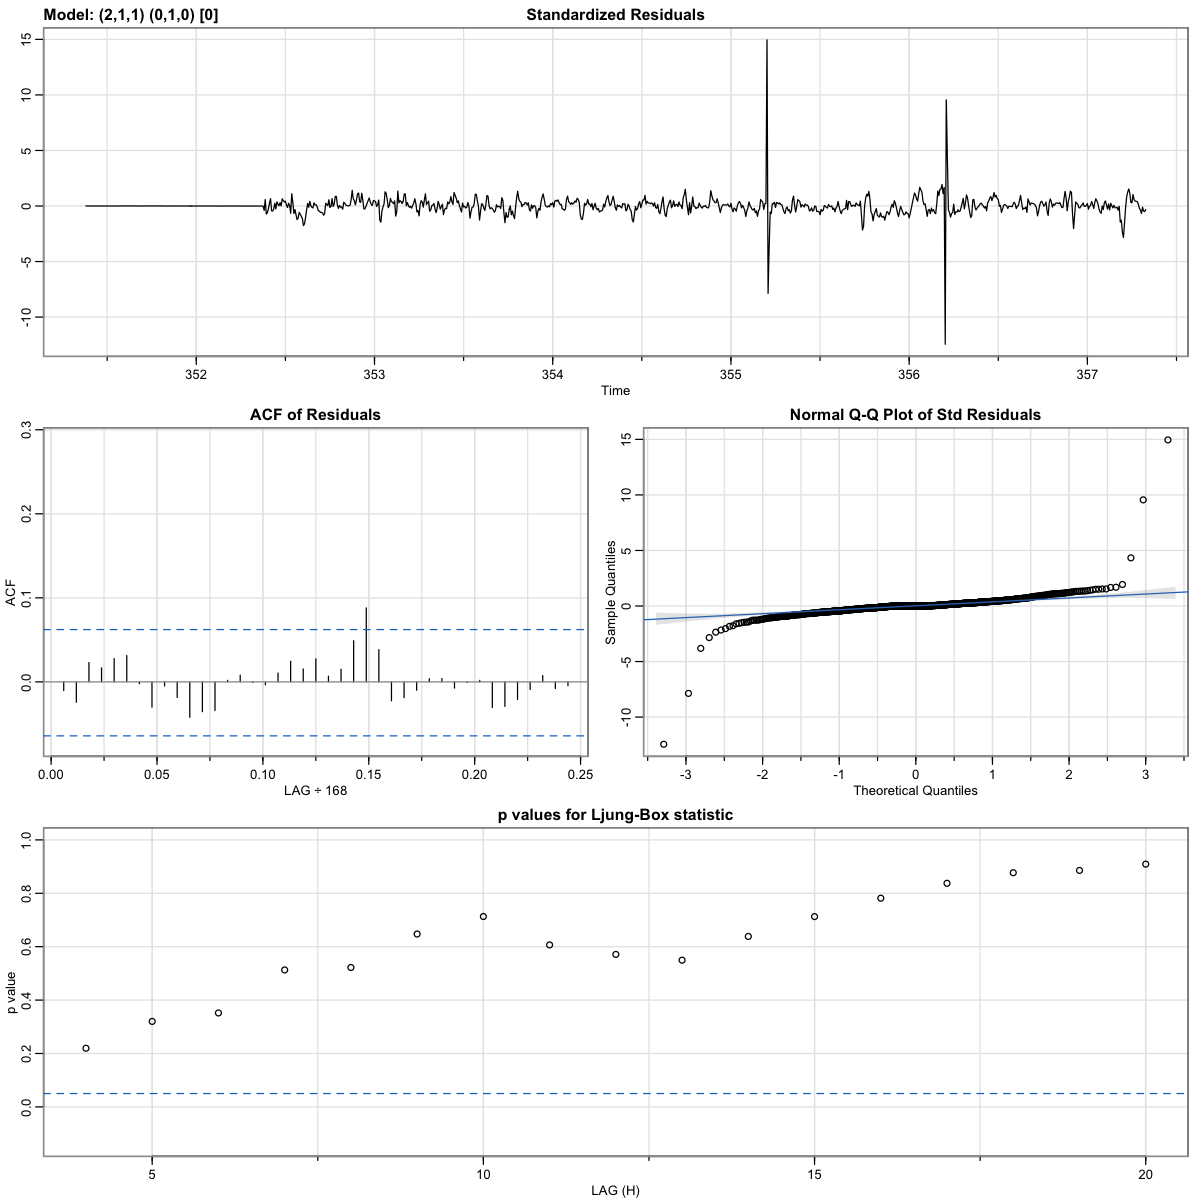

In [11]:
sarima(tail(test,1000),2,1,1,0,1,0,0)

## Results and Discussion

The result using SARIMA(2,1,1,)(0,1,0)[168] is summarized as above. ACF plot shows that the residuals are white noise, and it is also normally distributed, and all the p values of Ljung-Box statistic are greater than 0.05, which suggests that we fail to reject the null hypothesis that the residuals are independently distributed.

After I find that the model fits the data well, I used sarima.for() function to predict the next values, and the result is as below.

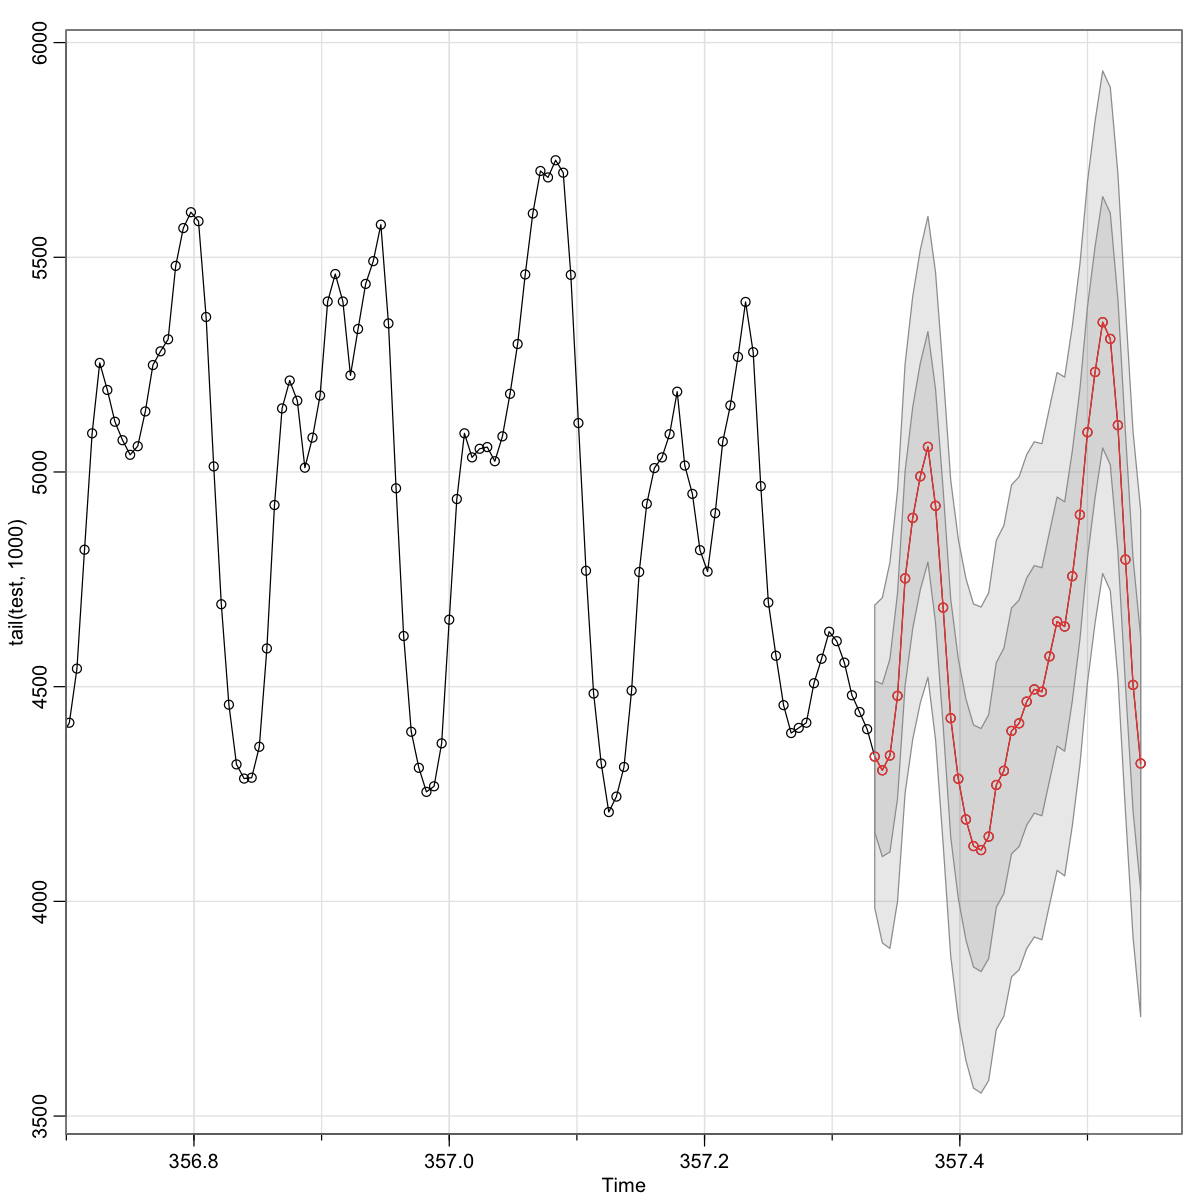

In [12]:
pred = sarima.for(tail(test,1000),36,2,1,1,0,1,0,0)

In [23]:
pred$pred[29]

[1] 5092.589

Using SARIMA(2,1,1)(0,1,0)[168] model, the Electric Energy Demand in Colorado on Sunday May 1st from 5-6 PM is expected to be 5092.59 MWh.

There is a limitation to be highlighted. As briefly mentioned in the section 3. Methodology, the dataset has a very clear annual seasonality, but it is not considered due to the significant
amount of time auto.arima() function takes. However, as indicated in PACF plot, the past values from the previous years are not strongly correlated to the recent values and especially to the next 36 future values. In addition, the SARIMA(2,1,1)(0,1,0) [168] model shows that the residuals are white noise, normally distributed and independent, and I consider this shows that the model fits the dataset well. Thus, I decide to consider only the recent 1,000 values for the prediction.